In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

* This notebook contains the complete code to run the test example of modeling the stock market time serie of Microsoft with LSTM neural networks considering the daily observations extrated between 2010 and 2018. The variations of the example are:
   
   
    1. Modeling the time serie only with LSTM.
    2. Same model, but adding a signal getting from the sentiment analysis of online news as extra feature in the model.

# 1. First model: modeling the stock market time serie without any extra features

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time

import matplotlib.ticker as tkr
%matplotlib inline

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
    
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

* The data set _df test 1_ contains the values of the stock market time serie

In [4]:
result= pd.read_pickle("data sets/data_to_paper_microsoft_case.pkl")

# original time serie (Y)
y = result.MSFT.values 
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)



# training and testing settings (size)
percent_of_training = 0.7
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
# 
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]


def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [5]:
result

,sentimental_analysis_split_by_dot_average,10,a,additional,agency,agreements,also,amsterdam,and,as,...,possess,pride,productive,productiveedge,signifies,specialized,successes,values,wyatt,MSFT
time,,,,,,,,,,,,,,,,,,,,,
2010-04-01,-0.0262,1.0000,3.0000,1.0000,2.0000,1.0000,1.0000,1.0000,7.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23.8074
2010-04-05,-0.0262,1.0000,3.0000,1.0000,2.0000,1.0000,1.0000,1.0000,7.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23.8972
2010-04-06,-0.0262,1.0000,3.0000,1.0000,2.0000,1.0000,1.0000,1.0000,7.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23.9380
2010-04-07,0.1611,1.0000,8.0000,0.0000,0.0000,0.0000,4.0000,0.0000,18.0000,7.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23.9625
2010-04-08,0.1611,1.0000,8.0000,0.0000,0.0000,0.0000,4.0000,0.0000,18.0000,7.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,24.4279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,-0.1977,0.0000,12.0000,0.0000,0.0000,0.0000,2.0000,0.0000,8.0000,2.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,92.4800
2018-03-22,0.5212,0.0000,10.0000,0.0000,0.0000,0.0000,3.0000,0.0000,13.0000,3.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,89.7900
2018-03-23,0.5212,0.0000,10.0000,0.0000,0.0000,0.0000,3.0000,0.0000,13.0000,3.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,87.1800


In [6]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)




# join the all the features in one
## reshape arrays
X_train_features = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))


In [7]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_features.shape[1], X_train_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_features, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               166400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________


In [8]:
train_predict = model.predict(X_train_features)
test_predict  = model.predict(X_test_features)




#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

Train Mean Absolute Error: 0.0062515875
Train Root Mean Squared Error: 0.009119034
Test Mean Absolute Error: 0.031625964
Test Root Mean Squared Error: 0.039537884


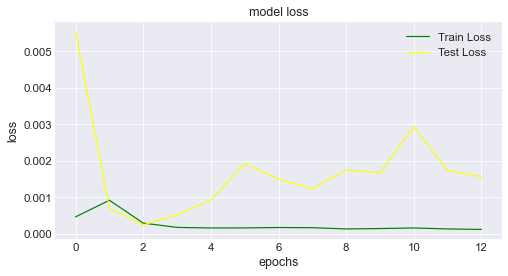

In [9]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')

plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

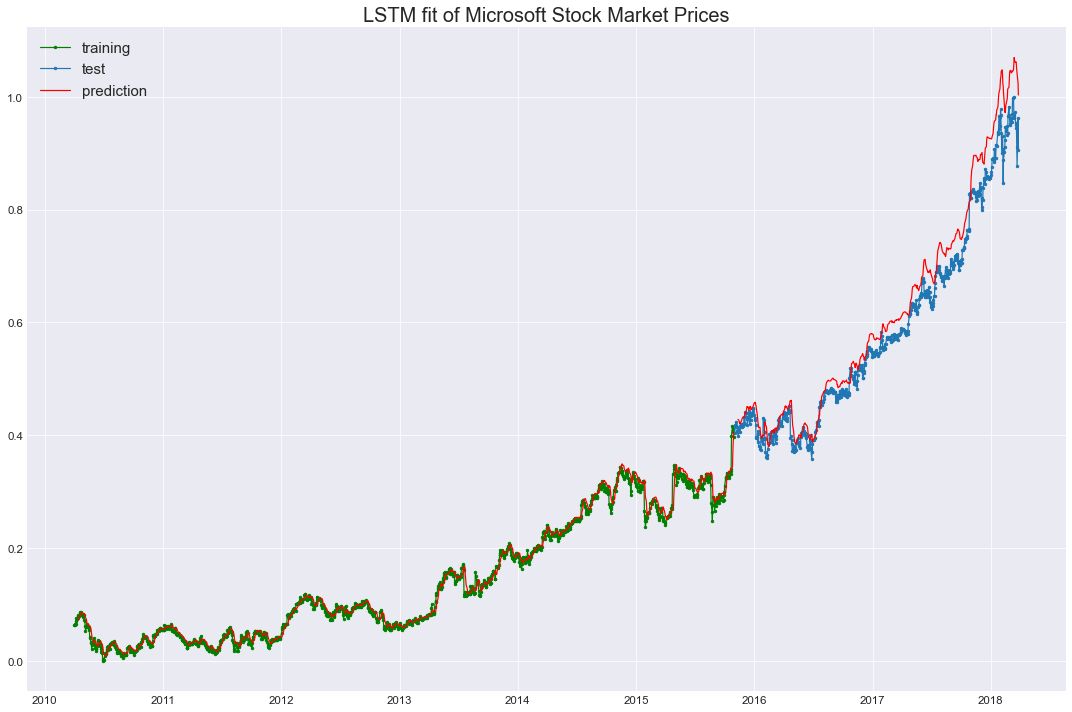

In [10]:
time_y_train = pd.DataFrame(data = train_y, index = result[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = result[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train,label = "training",color ="green",marker='.')
plt.plot(time_y_test,label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of Microsoft Stock Market Prices",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();

# 2. Second model: modeling the stock market time serie with the sentimen analysis of associated online news as extra features

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [12]:
result= pd.read_pickle("data sets/data_to_paper_microsoft_case.pkl")

# original time serie (Y)
y = result.MSFT.values #numpy.ndarray
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)


# extra information: features of the sentiment analysis
X = result.open.values
X = X.astype('float32')
X = np.reshape(X, (-1, 1))

# training and testing settings (size)
percent_of_training = 0.7
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
# 
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]
train_x, test_x = X[0:train_size,:], X[train_size:len(X),:]



def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [13]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)


# calculate extra features in (X)
X_train_features_2, auxiliar_1 = create_dataset(train_x, look_back)
X_test_features_2, auxiliar_2 = create_dataset(test_x, look_back)


# join the all the features in one
## reshape arrays
X_train_features_1 = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features_1  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))
X_train_features_2 = np.reshape(X_train_features_2, (X_train_features_2.shape[0], 1, X_train_features_2.shape[1]))
X_test_features_2  = np.reshape(X_test_features_2, (X_test_features_2.shape[0], 1, X_test_features_2.shape[1]))
## put all together
X_train_all_features = np.append(X_train_features_1,X_train_features_2,axis=1)
X_test_all_features = np.append(X_test_features_1,X_test_features_2,axis=1)


In [14]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_all_features.shape[1], X_train_all_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_all_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_all_features, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)
# history.history

model.summary()

NameError: name 'ModelCheckpoint' is not defined

In [15]:
# model = Sequential()
# # model.add(Embedding(vocab_size, 100))
# model.add(Bidirectional(LSTM(100)))
# model.add(Dense(1, activation='sigmoid'))

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

In [16]:
train_predict = model.predict(X_train_all_features)
test_predict  = model.predict(X_test_all_features)




#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

Train Mean Absolute Error: 0.14311795
Train Root Mean Squared Error: 0.17787574
Test Mean Absolute Error: 0.5878501
Test Root Mean Squared Error: 0.61301154


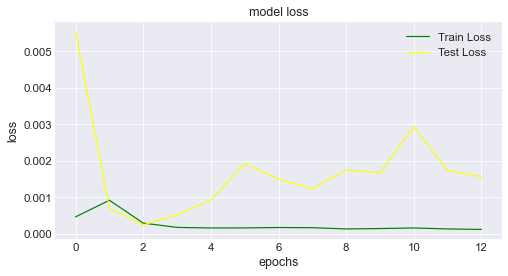

In [17]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')


plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

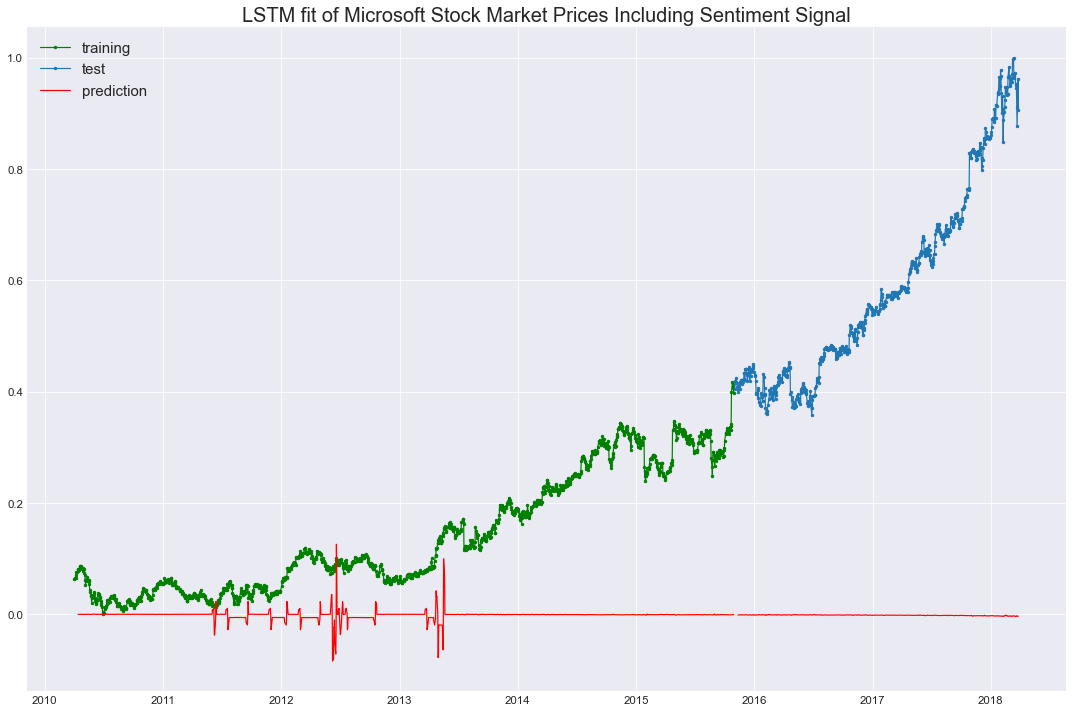

In [18]:
time_y_train = pd.DataFrame(data = train_y, index = result[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = result[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train,label = "training",color ="green",marker='.')
plt.plot(time_y_test,label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of Microsoft Stock Market Prices Including Sentiment Signal",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();

In [24]:
history = model.fit(X_train_all_features, X_test_all_features, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

ValueError: Data cardinality is ambiguous:
  x sizes: 1119
  y sizes: 595
Make sure all arrays contain the same number of samples.

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
#vocab_size는 단어 집합의 크기
X_train = tokenizer.texts_to_sequences(X_train)
X_vali = tokenizer.texts_to_sequences(X_vali)

NameError: name 'Tokenizer' is not defined

In [20]:
model = Sequential()
# model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

NameError: name 'X_train' is not defined